In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
folder_path = 'numpydata/'
file_names = os.listdir(folder_path)
print(file_names)
file_names = [file_name for file_name in file_names if file_name.endswith('.npy')]
file_names.sort()
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
labels = []
for file_name in file_names:
    if file_name.endswith('-L.npy'):
        labels.append('LoRa')
    elif file_name.endswith('-N.npy'):
        labels.append('Non-LoRa')
for file_path, label in zip(file_paths, labels):
    print(f"File: {file_path}, Label: {label}")

['.DS_Store', 'lorasf12_g0.0dB_att24dB_freq867.4MHz_1_combined-L.npy', 'lorasf7_g0.0dB_att12dB_freq867.4MHz_0_combined-L.npy', 'lorasf7_g0.0dB_att12dB_freq867.4MHz_1_combined-L.npy', 'lorasf12_g0.0dB_att24dB_freq867.4MHz_0_combined-L.npy', 'lorasf7_g0.0dB_att12dB_freq867.4MHz_4_combined-L.npy', 'lorasf12_g0.0dB_att24dB_freq867.4MHz_2_combined-L.npy', 'lorasf7_g0.0dB_att12dB_freq867.4MHz_3_combined-L.npy', 'lorasf7_g0.0dB_att12dB_freq867.4MHz_2_combined-L.npy', 'lorasf12_g0.0dB_att24dB_freq867.4MHz_3_combined-L.npy', 'lorasf12_g0.0dB_att24dB_freq867.4MHz_4_combined-L.npy']
File: numpydata/lorasf12_g0.0dB_att24dB_freq867.4MHz_0_combined-L.npy, Label: LoRa
File: numpydata/lorasf12_g0.0dB_att24dB_freq867.4MHz_1_combined-L.npy, Label: LoRa
File: numpydata/lorasf12_g0.0dB_att24dB_freq867.4MHz_2_combined-L.npy, Label: LoRa
File: numpydata/lorasf12_g0.0dB_att24dB_freq867.4MHz_3_combined-L.npy, Label: LoRa
File: numpydata/lorasf12_g0.0dB_att24dB_freq867.4MHz_4_combined-L.npy, Label: LoRa
File: 

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        array = np.load(self.file_paths[idx])
        if self.transform:
            array = self.transform(array)
        tensor = torch.tensor(array, dtype=torch.float64) 
        label = self.labels[idx]
        return tensor, label

In [4]:
dataset = CustomDataset(file_paths, labels)

In [5]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
for i, batch in enumerate(dataloader):
    print(f"Batch {i+1}:")
    print(batch)
    print("Batch size:", len(batch[0]))
    print()
    break

/var/folders/2d/fcgrngd95_b823fdj1fwwj840000gn/T/ipykernel_35402/2935055127.py:12: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699256357797/work/aten/src/ATen/native/Copy.cpp:299.)
  tensor = torch.tensor(array, dtype=torch.float64)


Batch 1:
[tensor([[-0.0039,  0.0039, -0.0039,  ...,  0.3333,  0.4588, -0.9137],
        [-0.2157,  0.8275, -0.8196,  ..., -0.8275,  0.7725,  0.0431],
        [ 0.0039, -0.0039, -0.0039,  ...,  0.8980, -0.6784, -0.0118],
        ...,
        [ 0.6863, -0.8980,  0.4980,  ..., -0.8824,  0.7412, -0.0980],
        [-0.0039, -0.0039,  0.0039,  ...,  0.0039,  0.0039, -0.0039],
        [-0.0039,  0.0039, -0.0039,  ..., -0.0039, -0.0039, -0.0039]],
       dtype=torch.float64), ('LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa')]
Batch size: 10



In [7]:
import numpy as np
from torchvision import transforms

class FFTTransform(object):
    def __call__(self, array):
        fft_result = np.fft.fft(array)
        magnitude = np.abs(fft_result)
        return magnitude

transform = transforms.Compose([
    FFTTransform(),  
])


In [8]:
datasetT = CustomDataset(file_paths,labels, transform=transform)

In [9]:
dataloaderT = DataLoader(datasetT, batch_size=batch_size, shuffle=True)

In [10]:
for i, batch in enumerate(dataloaderT):
    print(f"Batch {i+1}:")
    print(batch)
    print("Batch size:", len(batch[0]))
    print()
    break

Batch 1:
[tensor([[1.1959e+04, 4.3983e+00, 1.5834e+02,  ..., 6.3983e+01, 1.7223e+02,
         1.8477e+01],
        [1.2040e+04, 6.9196e+01, 2.1006e+02,  ..., 2.6891e+01, 2.0697e+02,
         5.3573e+01],
        [1.3409e+04, 1.8252e+01, 9.4719e+00,  ..., 2.2053e+01, 1.9883e+01,
         2.4524e+01],
        ...,
        [1.3414e+04, 1.3240e+01, 1.1801e+01,  ..., 1.1470e+01, 2.4421e+01,
         2.2123e+01],
        [1.1980e+04, 1.0498e+01, 1.6200e+02,  ..., 4.1213e+01, 1.7451e+02,
         2.3635e+01],
        [1.3432e+04, 2.3751e+01, 3.2503e+01,  ..., 3.1988e+01, 2.1301e+01,
         1.6840e+01]], dtype=torch.float64), ('LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa', 'LoRa')]
Batch size: 10



In [11]:
# import matplotlib.pyplot as plt
# # Iterate over the dataloader to view the batches of data
# for i, batch in enumerate(dataloader):
#     print(f"Batch {i+1}:")
#     # Visualize each tensor in the batch
#     for j, tensor in enumerate(batch[0]):
#         plt.figure()
#         plt.plot(tensor.numpy())
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.title(f'Tensor {j+1} in Batch {i+1}')
#         plt.show()
#     break


Batch 1:


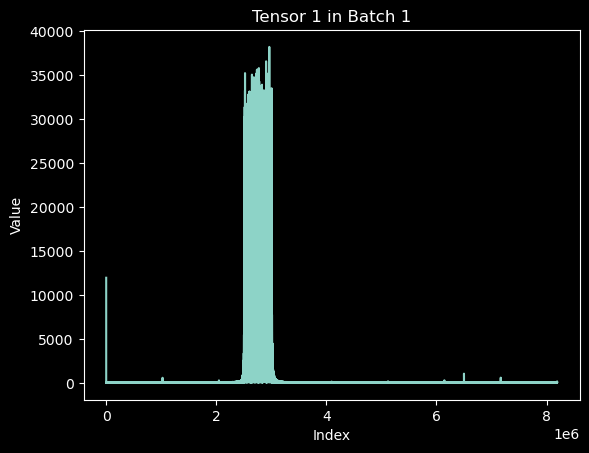

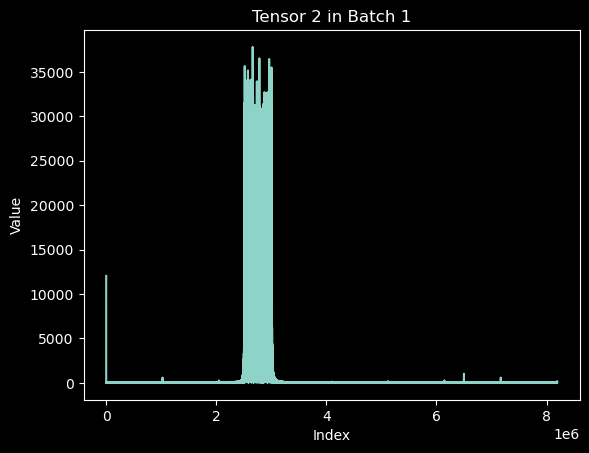

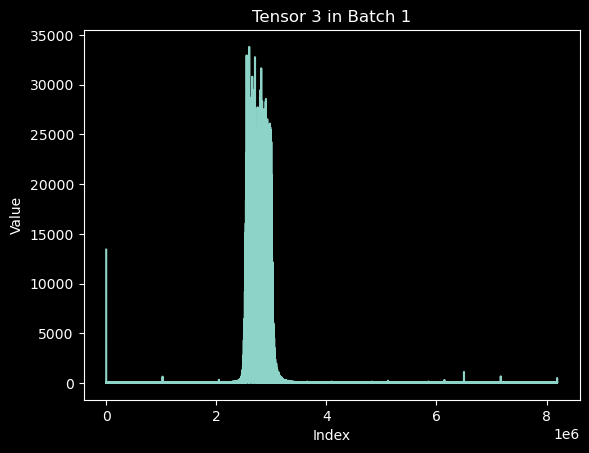

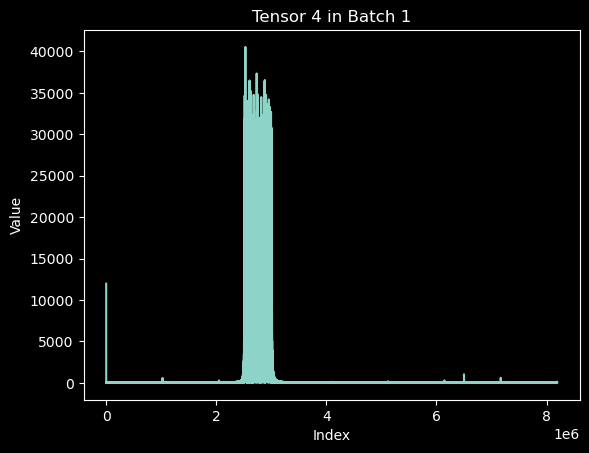

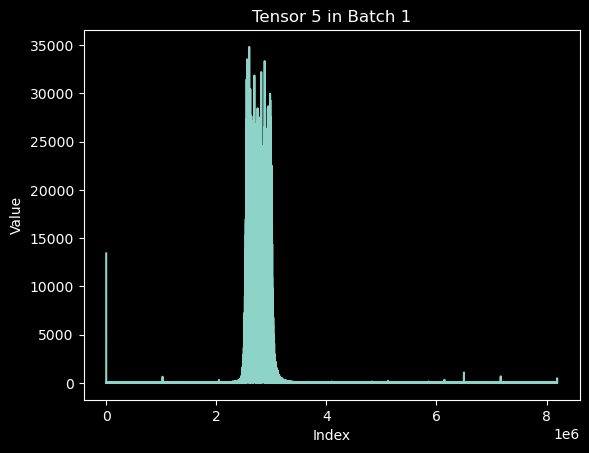

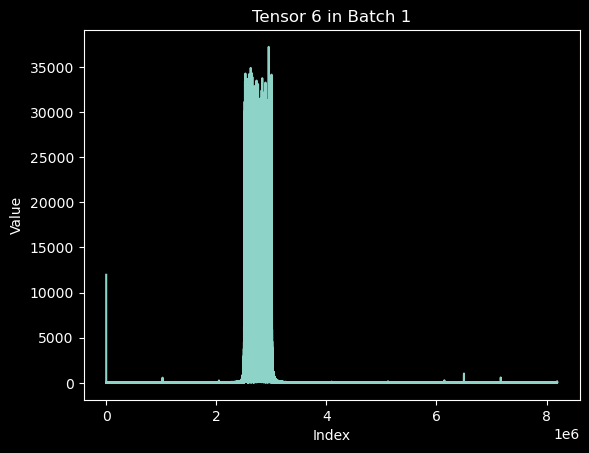

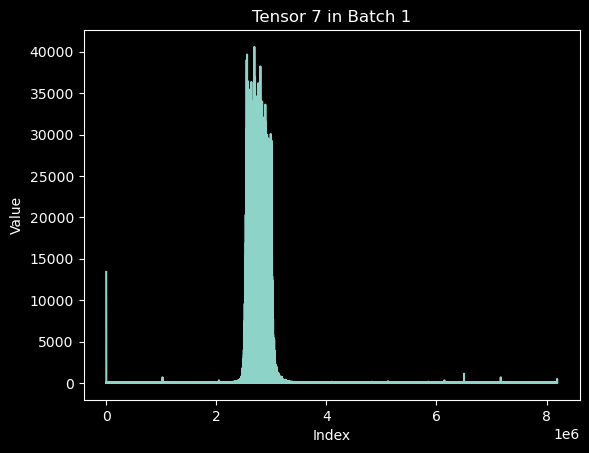

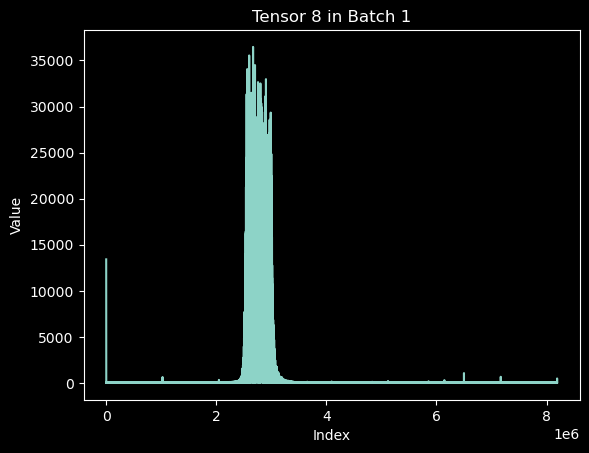

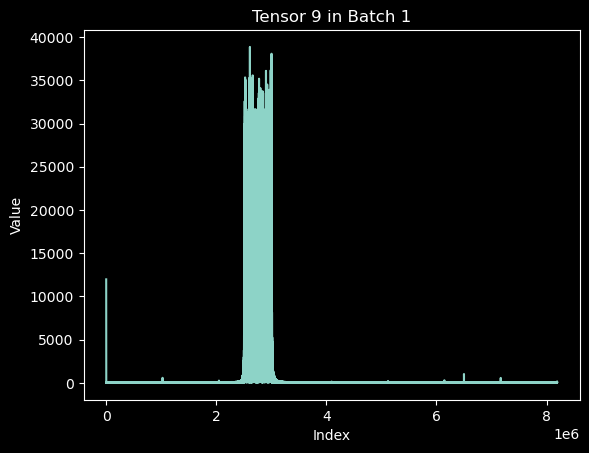

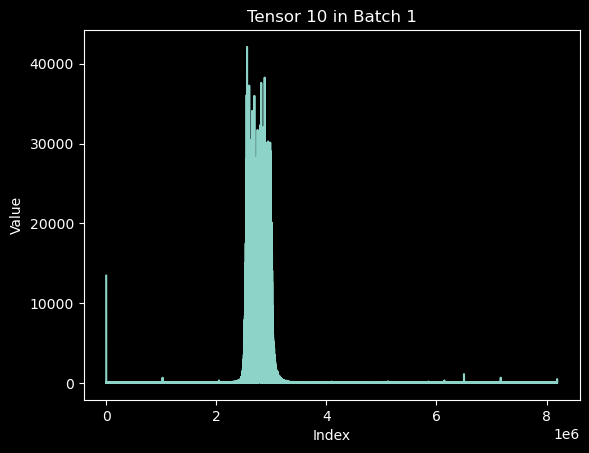

In [12]:
import matplotlib.pyplot as plt

# Iterate over the transformed dataset to view the samples
for i, transformed_sample in enumerate(dataloaderT):
    print(f"Batch {i+1}:")
    # Visualize each tensor in the batch
    for j, tensor in enumerate(batch[0]):
        plt.figure()
        plt.plot(tensor.numpy())
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title(f'Tensor {j+1} in Batch {i+1}')
        plt.show()


In [13]:
import torch.nn as nn


In [14]:
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        for _ in range(4):  # Repeat the conv layers 5 times
            self.conv_layers.add_module('conv_block', nn.Sequential(
                nn.Conv1d(128, 128, kernel_size=3),
                nn.ReLU(),
                nn.Conv1d(128, 128, kernel_size=3),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            ))
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 512, 256),  
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2), 
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.float()
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [15]:
model = CNN1D()


In [16]:
print(model)


CNN1D(
  (conv_layers): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=65536, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)


In [17]:
import torch.optim as optim


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [19]:
for epoch in range(num_epochs):
    model.train()    
    running_loss = 0.0
    correct = 0
    total = 0
    for data in dataloaderT:
        inputs, labels = data 
        print("Input tensor shape:", inputs.shape)
        print(inputs)
        reshaped_input = inputs.unsqueeze(1)
        print(reshaped_input.shape)
        optimizer.zero_grad()
        outputs = model(reshaped_input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloaderT):.4f}, Accuracy: {(correct/total)*100:.2f}%")

Input tensor shape: torch.Size([10, 8192000])
tensor([[1.3407e+04, 3.0623e+01, 2.8568e+01,  ..., 2.8468e+01, 8.1400e+00,
         1.9897e+01],
        [1.3414e+04, 1.3240e+01, 1.1801e+01,  ..., 1.1470e+01, 2.4421e+01,
         2.2123e+01],
        [1.1974e+04, 2.0268e+01, 1.6102e+02,  ..., 5.8019e+01, 1.4869e+02,
         3.6584e+01],
        ...,
        [1.2040e+04, 6.9196e+01, 2.1006e+02,  ..., 2.6891e+01, 2.0697e+02,
         5.3573e+01],
        [1.3432e+04, 2.3751e+01, 3.2503e+01,  ..., 3.1988e+01, 2.1301e+01,
         1.6840e+01],
        [1.1980e+04, 1.0498e+01, 1.6200e+02,  ..., 4.1213e+01, 1.7451e+02,
         2.3635e+01]], dtype=torch.float64)
torch.Size([10, 1, 8192000])


: 

In [ ]:
label_to_int = {'LoRa': 0, 'Non-LoRa': 1} 
inputs, labels = next(iter(dataloaderT))  
print(inputs)
# print(labels)
num_samples = inputs.size(0)
print(num_samples)

for i in range(num_samples):
    input_array = inputs[i].detach().numpy()  
    label_str = labels[i]  
    label_int = label_to_int[label_str]  
    plt.figure(figsize=(10, 5))
    plt.plot(input_array) 
    plt.title(f'Amplitude Spectrum of Input Signal (Sample {i+1}), Label: {label_str}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
